# Titanic Kaggle Competition, by [Andres Perez](https://www.andresperez.info/)
[README](./README.md)

## Imports

In [33]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

## Read in the Data

In [2]:
train = pd.read_csv('./data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('./data/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

## EDA
I've reviewed several previous submissions ([Dhruvin](https://www.kaggle.com/code/dhruvinkakadia/titanic-survival-classifier-top-2/notebook?scriptVersionId=87264651), and [Aditya](https://www.kaggle.com/code/adisonone/titanic/notebook?scriptVersionId=88680727)) so I already have some sense of the best features to use.

I'll be focusing mainly on:
- Passenger Class
- Sex
- Embarked

First off I'll combine the train and test sets for EDA

In [9]:
data = pd.concat([train, test]).reset_index(drop=True)

''

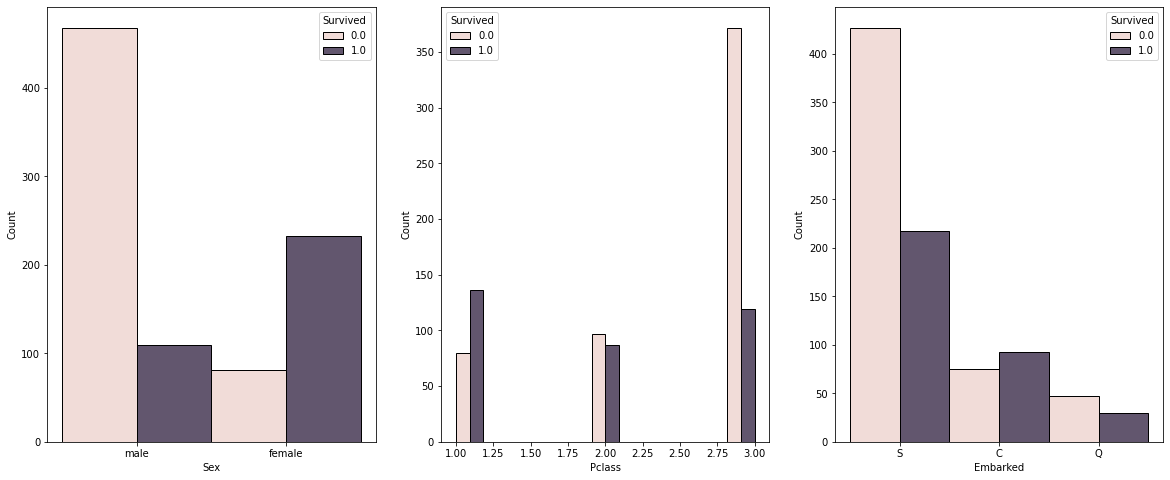

In [18]:
# With help from Dhruvin
plt.figure(figsize = [20, 8])
plt.subplot(1, 3, 1)
sns.histplot(data = data, x = data['Sex'], hue = data['Survived'], multiple = 'dodge')
plt.subplot(1, 3, 2)
sns.histplot(data = data, x = data['Pclass'], hue = data['Survived'], multiple = 'dodge')
plt.subplot(1, 3, 3)
sns.histplot(data = data, x = data['Embarked'], hue = data['Survived'], multiple = 'dodge')
;

### Survival Rates

In [19]:
# Survival Rates by Sex
data.groupby(["Sex"]).mean()["Survived"]


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [20]:
# Survival Rates by Pclass
data.groupby(["Pclass"]).mean()["Survived"]


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [21]:
# Survival Rates by Embarked
data.groupby(["Embarked"]).mean()["Survived"]


Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Females, first class passengers and those that embarked in Cherbourg have the highest survival rates.

## Data Processing

### Define target and features

In [26]:
# Target is the Survived column
y = train["Survived"]
y.value_counts(normalize=True)


0    0.616162
1    0.383838
Name: Survived, dtype: float64

Normalized value counts show a 38.38% survival rate, and our baseline is 61.62% accuracy!

In [27]:
# Features are Pclass, Sex and Embarked
X = pd.get_dummies(train[['Pclass', 'Sex', 'Embarked']])
X_test = pd.get_dummies(test[['Pclass', 'Sex', 'Embarked']])
X.head()

,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0,1,0,0,1
1,1,1,0,1,0,0
2,3,1,0,0,0,1
3,1,1,0,0,0,1
4,3,0,1,0,0,1


In [28]:
X_test.head()

,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0,1,0,1,0
1,3,1,0,0,0,1
2,2,0,1,0,1,0
3,3,0,1,0,0,1
4,3,1,0,0,0,1


## Train-Test split

In [29]:
# Named test splits val for validation. Stratified since data is unbalanced
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=1331)

## Modeling

I'm going to Grid Search parameters for an XGBoost Classifier

### XGBoost
This code cell is commented out to be run only in Collab/Kaggle

In [32]:
# # Instantiate classifier
# xgb = XGBClassifier(use_label_encoder=False)
# # Using same params as Dhruvin to start
# params = {
#     "max_depth": range(2, 10, 2),
#     "n_estimators": range(26, 46, 2),
#     "learning_rate": [0.2, 0.1, 0.03, 0.01],
# }
# # Instantiate Grid Search
# xgb_gs = GridSearchCV(xgb, params, n_jobs=-1)
# # Fit on training data
# xgb_gs.fit(X_train, y_train)
# # Save best estimator
# xgb_best = xgb_gs.best_estimator_
# # Return best parameters, validation score and training score
# xgb_gs.best_params_, xgb_gs.score(X_val, y_val), xgb_gs.score(X_train, y_train)


### Extra Trees

In [34]:
# Instantiate classifier
et = ExtraTreesClassifier()
# Using same params as Dhruvin to start
params = {
    "n_estimators": range(8, 28, 4),
    "max_depth": range(24, 48, 4),
    "max_leaf_nodes": range(20, 48, 4),
}
# Instantiate Grid Search
et_gs = GridSearchCV(et, params, n_jobs=-1)
# Fit on training data
et_gs.fit(X_train, y_train)
# Save best estimator
et_best = et_gs.best_estimator_
# Return best parameters, validation score and training score
et_gs.best_params_, et_gs.score(X_val, y_val), et_gs.score(X_train, y_train)


({'max_depth': 24, 'max_leaf_nodes': 20, 'n_estimators': 8},
 0.8430493273542601,
 0.8008982035928144)